In [1]:
from wyckoff_transformer.generator import WyckoffGenerator

In [2]:
generator, wandb_run, tensors, tokenisers, engineers = WyckoffGenerator.from_wandb_run("yj1cme83")

/home/kna/WyckoffTransformer/wyckoff_transformer/generator.py:67: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(Path("runs", wandb_run_id, "

In [3]:
from cascade_transformer.dataset import AugmentedCascadeDataset, jagged_batch_randperm
from omegaconf import OmegaConf
import torch
device = torch.device("cpu")
config = OmegaConf.create(dict(wandb_run.config))
masks_dict = {field: tokenisers[field].mask_token for field in config.model.cascade.order}
pad_dict = {field: tokenisers[field].pad_token for field in config.model.cascade.order}
stops_dict = {field: tokenisers[field].stop_token for field in config.model.cascade.order}
num_classes_dict = {field: len(tokenisers[field]) for field in config.model.cascade.order}
test_dataset = AugmentedCascadeDataset(
            data=tensors["test"],
            cascade_order=config.model.cascade.order,
            masks=masks_dict,
            pads=pad_dict,
            stops=stops_dict,
            num_classes=num_classes_dict,
            start_field=config.model.start_token,
            augmented_field=config.tokeniser.augmented_token_fields[0],
            dtype=torch.long,
            start_dtype=torch.float,
            device=device)
train_dataset = AugmentedCascadeDataset(
            data=tensors["train"],
            cascade_order=config.model.cascade.order,
            masks=masks_dict,
            pads=pad_dict,
            stops=stops_dict,
            num_classes=num_classes_dict,
            start_field=config.model.start_token,
            augmented_field=config.tokeniser.augmented_token_fields[0],
            dtype=torch.long,
            start_dtype=torch.float,
            device=device)

In [4]:
high_temperature_tensors = generator.generate_tensors(test_dataset.start_tokens, temperature=100)
high_temperature_data = dict(zip(config.model.cascade.order, high_temperature_tensors))
high_temperature_data[config.model.start_token] = test_dataset.start_tokens

In [5]:
high_temperature_dataset = AugmentedCascadeDataset(
            data=high_temperature_data,
            cascade_order=config.model.cascade.order,
            masks=masks_dict,
            pads=pad_dict,
            stops=stops_dict,
            num_classes=num_classes_dict,
            start_field=config.model.start_token,
            augmented_field=None,
            dtype=torch.long,
            start_dtype=torch.float,
            device=device)

In [6]:
high_temperature_log_likelihoods = generator.compute_likelihoods(high_temperature_dataset, 10, 1)

In [7]:
test_log_likelihoods = generator.compute_likelihoods(test_dataset, 10, 10)

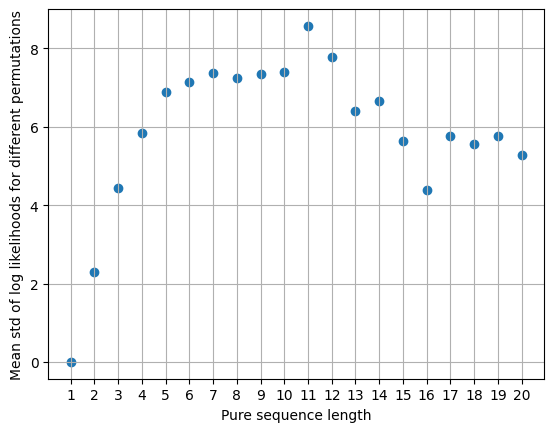

In [8]:
import matplotlib.pyplot as plt
std_per_len = []
std_permutation = test_log_likelihoods.std(dim=0).mean(dim=0)
for i in range(1, test_dataset.pure_sequences_lengths.max() + 1):
    std_per_len.append(std_permutation[test_dataset.pure_sequences_lengths == i].mean().item())
fig, ax = plt.subplots()
ax.scatter(range(1, test_dataset.pure_sequences_lengths.max() + 1), std_per_len)
ax.set_xlabel("Pure sequence length")
ax.set_ylabel("Mean std of log likelihoods for different permutations")
ax.set_xticks(range(1, test_dataset.pure_sequences_lengths.max() + 1))
ax.grid();

In [9]:
train_log_likelihoods = generator.compute_likelihoods(train_dataset, 10, 10)

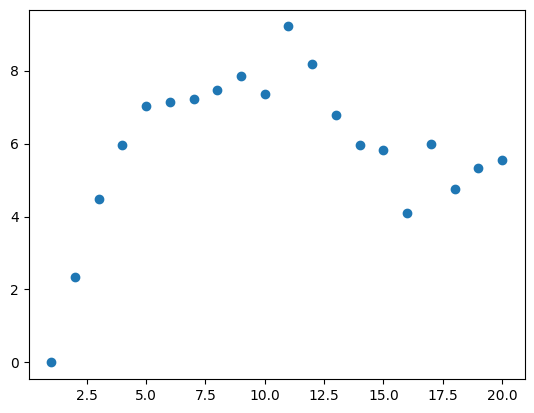

In [10]:
std_per_len = []
std_permutation = train_log_likelihoods.std(dim=0).mean(dim=0)
for i in range(1, test_dataset.pure_sequences_lengths.max() + 1):
    std_per_len.append(std_permutation[train_dataset.pure_sequences_lengths == i].mean().item())
fig, ax = plt.subplots()
ax.scatter(range(1, train_dataset.pure_sequences_lengths.max() + 1), std_per_len);

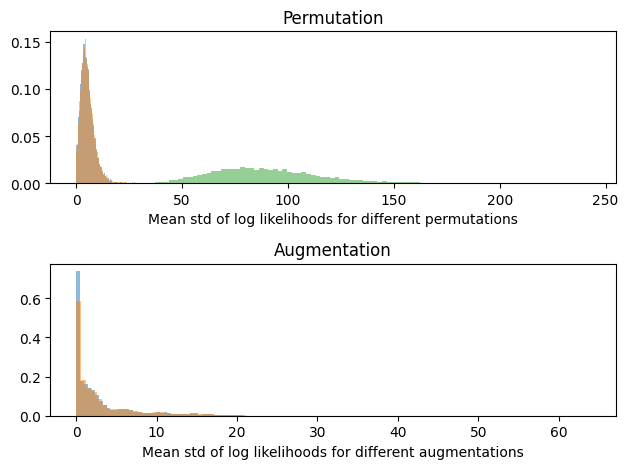

In [20]:
fig, (ax_permuation, ax_augmentation) = plt.subplots(2, 1)
for log_likelihoods in (test_log_likelihoods, train_log_likelihoods, high_temperature_log_likelihoods):
    relative_std_permutation = (log_likelihoods.std(dim=0)).mean(dim=0)
    ax_permuation.hist(relative_std_permutation, bins=100, density=True, alpha=0.5)
    if log_likelihoods.shape[1] > 1:
        relative_std_augmentation = (log_likelihoods.std(dim=1)).mean(dim=0)
        ax_augmentation.hist(relative_std_augmentation, bins=100, density=True, alpha=0.5)
ax_permuation.set_title("Permutation")
ax_permuation.set_xlabel("Mean std of log likelihoods for different permutations")
ax_augmentation.set_title("Augmentation")
ax_augmentation.set_xlabel("Mean std of log likelihoods for different augmentations")
fig.tight_layout();

In [15]:
high_temperature_log_likelihoods.mean()

tensor(-1704.2650)

In [17]:
test_log_likelihoods.mean()

tensor(-94.3274)